In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import peakutils


/home/sam/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



## Generate sine wave data points

In [2]:
# #Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.4
points_per_cycle = int((2*np.pi) / sample_rate)*10


x_range = np.arange(start=-np.pi/2, stop=80*2*np.pi, step=sample_rate)
print(max(x_range))
mult_start = 0.9
mult_end = 0.7
mult_range = mult_end - mult_start

period_multiplier = np.arange(mult_start, mult_end, mult_range/len(x_range))
#b = np.arange(0.5, 1, 1/len(a))
data = [np.sin(i*j) for i,j in zip(x_range, period_multiplier)]
#Shift the dataset up so we can use -1 as our NaN value
shiftData = [data[i] + -min(data) for i in range(len(data))] 
data = shiftData
print(data[0:10])
print(len(data))
print(min(data))

502.429203673205
[0.012269616997201527, 0.1307832193752353, 0.3607467044188979, 0.672567726797805, 1.0262197165275833, 1.3763908408784598, 1.6782929762366314, 1.8933855894375828, 1.994283661381456, 1.968226250132417]
1261
0.0


In [3]:
dataframe = pd.read_excel('../../130N_Cycles_1-47.xlsx')

In [4]:
df = dataframe.drop('time', 1)


#Store as a numpy ndarray
data = df.values
data = data.astype('float32')

data = data[0::60]

new_data = []


for i in range(len(data)):
    new_data.append(round(float(data[i]), 2))

print(new_data[0:10])


data = new_data

print("Total data points: " + str(len(new_data)))

[0.07, 0.36, 1.19, 2.39, 4.27, 7.03, 10.84, 16.02, 22.84, 31.91]
Total data points: 2836


## Grab the start and end points of each cycle

In [5]:
#Negate force values to find a trough using the same peak function
negated_vals = [-i for i in data]

#Grab the peak and trough times (these are also indices)
peak_times = peakutils.indexes(data, thres=0.5, min_dist=0.1)
trough_times = peakutils.indexes(negated_vals, thres=0.5, min_dist=0.1)

#Find the time's corresponding y value
peak_vals = [data[i] for i in peak_times]
trough_vals = [data[i] for i in trough_times]

print(len(peak_times))

47


## Plot the raw data

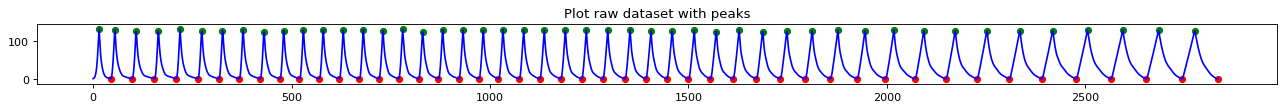

In [6]:
# (1) Plot whole dataset
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")
plt.title('Plot raw dataset with peaks')

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)
plt.show()

## Generate a dataset using padding

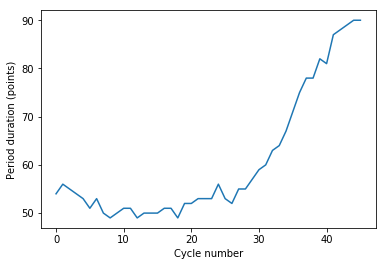

49
90
60


In [7]:
#Collect all the period values from the dataset
periods = []
for i in range(len(trough_times) - 1):
    period = trough_times[i+1] - trough_times[i]
    periods.append(period)
plt.plot(periods)
plt.xlabel('Cycle number')
plt.ylabel('Period duration (points)')

plt.show()

print(min(periods))
print(max(periods))
print(sum(periods)/len(periods))

In [8]:


#Always capture three full waves. A single wave is represented by peak-to-peak. So each example needs a 3 peaks pairs.

#To capture cycles without starting and ending at only peaks each time, 
# use percentages of points realtive to the distance(num points) between the two peaks.
# so if an example starts n points before the first peak, then use n/(n_cyle_points) as the num points to use ahead



"""
Algorithm

3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed
and adding P more points to the end. 


1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time


2. In Loop
    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".
    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    


3.Last stage should just pad each example so they're all of the same dimension
    
    
    Use percentage offset of points from a peak to approximate where to end. 
        (for example that doesnt perfectly capture all peaks)




***Maybe idea is that it should always have at least enough peaks to form n-1 waves and 
extrapolate the rest based on previously seen info

Maybe should always see n peaks, and expand if not

"""





'\nAlgorithm\n\n3 periods is given by: counting points up until first peak (P), then going until 3 peaks have passed\nand adding P more points to the end. \n\n\n1. Init containers for examples (holding Xs and Ys). Init pointer to step along ~1 point at a time\n\n\n2. In Loop\n    a. Aggregate and count how many points passed before first peak seen. Set this value as int "passed".\n    b. Continue collecting points until 3 peaks seen. Then proceed for another "passed" points. Done.    \n\n\n3.Last stage should just pad each example so they\'re all of the same dimension\n    \n    \n    Use percentage offset of points from a peak to approximate where to end. \n        (for example that doesnt perfectly capture all peaks)\n\n\n\n\n***Maybe idea is that it should always have at least enough peaks to form n-1 waves and \nextrapolate the rest based on previously seen info\n\nMaybe should always see n peaks, and expand if not\n\n'

## Example generation with pandas dataframe 

In [9]:
#Maybe include component of data set that feeds in the number of points over 0 as a label

def generate_dataset(data, peak_times, trough_times, x_cycles=3, y_cycles=1):
    """
    - Each X and label is "set" in size (will contain variable num of useless datapoints at end)
    - So we combine these adjacent to one another and stack all examples vertically 
    TODO: We should make the length grow from the inside out; the prev points should extend backwards?***
    #TODO: Maybe dont split the train inside here, maybe just output a train and test var
    #TODO: Try testing on earlier wave? See if it just predicts something smaller than later wave? 
       We cant use seen data already, so maybe dont train on first 4 waves, and dont train on last 4 waves.
    """
    #Set some variables to use
    smallest_period = peak_times[1] - peak_times[0]
    largest_period = peak_times[-1] - peak_times[-2]
    print("Smallest Period: " + str(smallest_period))
    print("Largest Period: " + str(largest_period))
    period_range = largest_period - smallest_period
    holder_size = int(largest_period * 1.4)
    print("HOLDER Size: " + str(holder_size))
    print("")
    #--------Grab the data to be used for testing, so it doesnt contaminate at all----------
    
    #Calculate using peaks how much data we need for x_cycles + y_cycles
    
    #Collect enough points to see x_cycles + y_cycles periods & start halfwave in between peak and trough
    num_test_cycles = x_cycles + y_cycles
    start_peak_time = peak_times[-num_test_cycles]
    one_trough_prior_time = trough_times[-(num_test_cycles+1)]
    
    
    test_in_start = int(start_peak_time - (start_peak_time - one_trough_prior_time))
    print(test_in_start)

    #Find when test_in ends and test_out starts
    #Between the second-to-last trough and last peak
    snd_to_last_trough = trough_times[-2]
    last_peak = peak_times[-1]
    test_out_start = int(last_peak - (last_peak - snd_to_last_trough))
    print(test_out_start)
    
    
    print("---------------------Finding test set size-----------------------")
    print("test_start_time: " + str(test_in_start))
    print("len total data: " + str(len(data)))
    print("")
    test_in = data[test_in_start:test_out_start]
    test_out = data[test_out_start:]
    
    #Remove this test data from the train set
    data = data[:test_in_start]
    
    #Store the test data within the default containers
    test_in_container = [-1]* (holder_size*x_cycles)
    print("unpopulated test_in_container size: " + str(len(test_in_container)))
    test_in_container[-len(test_in):] = test_in
    print("populated test_in_container size: " + str(len(test_in_container)))
    print("actual test_in data size: " + str(len(test_in)))

    print("")
    
    
    test_out_container = [-1]* (holder_size*y_cycles)
    print("unpopulated test_out_container size: " + str(len(test_out_container)))
    test_out_container[:len(test_out)] = test_out
    print("unpopulated test_out_container size: " + str(len(test_out_container)))
    print("actual test_out data size: " + str(len(test_out)))
    

    
    print("len test_in: " + str(len(test_in)))
    print("len test_out: " + str(len(test_out)))

    print("len train data: " + str(len(data)))
    print("")

    
    
    
#     num_test_points = holder_size* (x_cycles + y_cycles)
#     test = data[-num_test_points:]
#     data = data[:-num_test_points]
    
    
    
    #holder_size = default_period
    #Assign an approximate period-value to each point over the distribution from smallest to largest
    approx_periods = [int(smallest_period + i) for i in np.linspace(0, period_range, len(data))]
    
    #Set the variable number of points to use on first iteration
    n_prev = smallest_period * x_cycles
    n_forecast = smallest_period * y_cycles
    
    
    #Init the pandas dataframe to hold our new dataset (TODO!!! probably modularize into seperate function)
    col_names = list()

    for i in range(holder_size*x_cycles, 0, -1):
        col_names += ['var(t-%d)' %  i]
    
    for i in range(0, holder_size*y_cycles):
        if i == 0:
            col_names += ['var(t)']
        else:
            col_names += ['var(t+%d)' % i]

    df = pd.DataFrame(columns = col_names)
    
    print("Just after creation, the df is shape: " + str(df.shape))
    
    #Loop over the data and convert into samples
    for i in range(len(data)):
        #print("----------In Loop: i= "+str(i)+" ---------------------" )
        
        #Exit if we dont have enough points remaining to construct another example
        if((i+n_prev) > len(data) or (i+n_prev+n_forecast) > len(data)):
            print("we're breaking!")
            break
        
        #Init our examples input and label (TODO!!! combine these lines into one as x & y in same row now)
        x = [-1]* (holder_size*x_cycles)
        #print("x size: " +str(len(x)))
        y = [-1]* (holder_size*y_cycles)
        #print("y size: " +str(len(y)))

        #print("X is of size: " + str(len(x)))
        
        #Set real values in the default size holders
        #print("LOOK HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        #print(len(x[-n_prev:]))
        #print(len(data[i:i+n_prev]))
        x[-n_prev:] = data[i:i+n_prev] #Store at the end of the array
        y[:n_forecast] = data[i+n_prev:i+n_prev+n_forecast] #Store at the beginning of the array
        
        #Add the x & y pair as a row in the dataframe
        df.loc[i] = x + y 
        
        #Calculate the new period to use
        new_period_size = int(np.average(approx_periods[i:i+n_prev]))
        n_prev = new_period_size*3
        n_forecast = new_period_size
        #print("new period size: " + str(new_period_size))
        

    print("num points: " +str(len(data)))
    print("dataframe shape:" + str(df.shape))

    #Set the figure parameters
    #fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

    len_final_example = n_prev + n_forecast
    
    #Remeber: iloc works with weird indexing: [rows, cols]
    #First index is rows and second is columns
    
    #train_examples = df.iloc[:-1, :holder_size*x_cycles]
    #train_labels = df.iloc[:-1, holder_size*x_cycles:]
    
    #test_example = df.iloc[-1, :holder_size*x_cycles]
    #test_label = df.iloc[-1, holder_size*x_cycles:]

    #Return the training dataframe, the test vector, and the default holder size
    return df, test_in_container, test_out_container, holder_size, x_cycles, y_cycles

    
    #return train_examples,train_labels, test_example, test_label, sizzzzzze

## Building the dataset

In [10]:
# new_exper_data = [i for i in range(30)]
# default_period = 5
# new_exper_peak_times = [0,1,2,4,6,8,11, 13, 16, 18, 21, 25, 30 ]

#train_examples, train_labels, test_example, test_label = generate_dataset(data, peak_times)
df_train, test_in, test_out, holder_size, x_cycles, y_cycles = generate_dataset(data, peak_times, trough_times)

print("df_train: " + str(df_train.shape))
train_examples = df_train.iloc[:, :holder_size*x_cycles]
train_labels = df_train.iloc[:, holder_size*x_cycles:]

#test_example = test_array[:holder_size*3]
#test_label = test_array[:holder_size*3]
print("")
print("HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("train_examples: " + str(train_examples.shape))
print("train_labels: "+ str(train_labels.shape))
print("")
print("len test_in: " + str(len(test_in)))
print("len test_out: " + str(len(test_out)))
print(holder_size)


# print("test_example: "+ str(len(test_example)))
# print("test_label: " + str(len(test_label)))

# print(test_example.iloc[100:105])
# print(train_examples.iloc[-1,100:105])
#print(test_example)
#print(test_label)

Smallest Period: 40
Largest Period: 91
HOLDER Size: 127

2477
2744
---------------------Finding test set size-----------------------
test_start_time: 2477
len total data: 2836

unpopulated test_in_container size: 381
populated test_in_container size: 381
actual test_in data size: 267

unpopulated test_out_container size: 127
unpopulated test_out_container size: 127
actual test_out data size: 92
len test_in: 267
len test_out: 92
len train data: 2477

Just after creation, the df is shape: (0, 508)
we're breaking!
num points: 2477
dataframe shape:(2134, 508)
df_train: (2134, 508)

HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
train_examples: (2134, 381)
train_labels: (2134, 127)

len test_in: 381
len test_out: 127
127


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [11]:
# fit an LSTM network to training data

def fit_lstm(X, y, n_batch, nb_epoch):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    #X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    

    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print("sam")
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(400,return_sequences=True,batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=False))
    model.add(LSTM(256))
    model.add(Dense(128))
    
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    #Fit the network to the training data
    history = model.fit(X, y,validation_split=0.125, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    

    return model, architecture, history

In [12]:
#Cut off some training data if necessary for batch sizes
print(train_examples.shape)
train_examples_cut = train_examples[86:]
print(train_examples_cut.shape)

print(train_labels.shape)
train_labels_cut = train_labels[86:]
print(train_labels_cut.shape)

print("Here")
print(train_examples_cut.shape)
print(train_labels_cut.shape)

(2134, 381)
(2048, 381)
(2134, 127)
(2048, 127)
Here
(2048, 381)
(2048, 127)


## Train the Neural Network

In [ ]:
n_epochs = 1500
n_batch = 256
#n_neurons = 400
#print("train shape: " + str(train.shape))
#train_cut = train[:-2,:]
#train_cut = train
#print("train shape: " + str(train_cut.shape))
print("train shape: " +str(train_examples.shape))
model, architecture, history = fit_lstm(train_examples_cut.values, train_labels_cut.values, n_batch, n_epochs)


train shape: (2134, 381)
X shape: (2048, 381)
y shape: (2048, 127)
sam
(256, 381, 1)
(2048, 381, 1)
Train on 1792 samples, validate on 256 samples
Epoch 1/1500
1792/1792 [==============================] - 13s 7ms/step - loss: 1084.4263 - acc: 0.0229 - val_loss: 1841.5128 - val_acc: 0.0117
Epoch 2/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 965.7501 - acc: 0.0229 - val_loss: 1639.1284 - val_acc: 0.0078
Epoch 3/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 821.9131 - acc: 0.0184 - val_loss: 1393.2745 - val_acc: 0.0078
Epoch 4/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 705.0123 - acc: 0.0184 - val_loss: 1195.2465 - val_acc: 0.0078
Epoch 5/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 677.3813 - acc: 0.0184 - val_loss: 1114.7333 - val_acc: 0.0078
Epoch 6/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 686.1588 - acc: 0.0206 - val_loss: 1110.4268 - val_acc: 0.0234


1792/1792 [==============================] - 11s 6ms/step - loss: 414.4494 - acc: 0.0692 - val_loss: 915.3302 - val_acc: 0.0117
Epoch 58/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 406.4685 - acc: 0.0737 - val_loss: 913.9346 - val_acc: 0.0117
Epoch 59/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 400.1949 - acc: 0.0753 - val_loss: 908.7721 - val_acc: 0.0117
Epoch 60/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 394.0048 - acc: 0.0653 - val_loss: 918.3489 - val_acc: 0.0117
Epoch 61/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 384.5548 - acc: 0.0737 - val_loss: 878.9071 - val_acc: 0.0117
Epoch 62/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 378.4799 - acc: 0.0692 - val_loss: 885.6321 - val_acc: 0.0117
Epoch 63/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 372.9397 - acc: 0.0831 - val_loss: 864.7822 - val_acc: 0.0117
Epoch 64/1500
1792/1

1792/1792 [==============================] - 11s 6ms/step - loss: 334.8392 - acc: 0.1138 - val_loss: 719.4951 - val_acc: 0.0195
Epoch 115/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 347.7743 - acc: 0.0513 - val_loss: 772.0083 - val_acc: 0.0156
Epoch 116/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 372.4046 - acc: 0.1261 - val_loss: 911.0934 - val_acc: 0.0195
Epoch 117/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 348.8862 - acc: 0.0843 - val_loss: 811.7371 - val_acc: 0.0273
Epoch 118/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 348.6144 - acc: 0.0469 - val_loss: 820.4372 - val_acc: 0.0117
Epoch 119/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 339.4843 - acc: 0.0770 - val_loss: 797.5593 - val_acc: 0.0117
Epoch 120/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 336.5323 - acc: 0.0636 - val_loss: 774.1918 - val_acc: 0.0195
Epoch 121/1500

1792/1792 [==============================] - 12s 6ms/step - loss: 300.7455 - acc: 0.1071 - val_loss: 667.0349 - val_acc: 0.0352
Epoch 172/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 300.5110 - acc: 0.1094 - val_loss: 665.7404 - val_acc: 0.0508
Epoch 173/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 301.4069 - acc: 0.1239 - val_loss: 670.8568 - val_acc: 0.0391
Epoch 174/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 302.0152 - acc: 0.0999 - val_loss: 656.5708 - val_acc: 0.0742
Epoch 175/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 303.1489 - acc: 0.1367 - val_loss: 676.3144 - val_acc: 0.0312
Epoch 176/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 301.3421 - acc: 0.0977 - val_loss: 652.1718 - val_acc: 0.0391
Epoch 177/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 301.1126 - acc: 0.1295 - val_loss: 686.2067 - val_acc: 0.0273
Epoch 178/1500

1792/1792 [==============================] - 12s 6ms/step - loss: 242.9616 - acc: 0.1702 - val_loss: 612.7221 - val_acc: 0.0117
Epoch 229/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 242.2511 - acc: 0.1596 - val_loss: 599.9431 - val_acc: 0.0312
Epoch 230/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 246.5933 - acc: 0.1881 - val_loss: 612.7527 - val_acc: 0.0273
Epoch 231/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 240.9714 - acc: 0.1562 - val_loss: 592.4769 - val_acc: 0.0312
Epoch 232/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 243.9999 - acc: 0.1763 - val_loss: 610.6859 - val_acc: 0.0156
Epoch 233/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 238.4916 - acc: 0.1490 - val_loss: 595.8948 - val_acc: 0.0234
Epoch 234/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 234.3131 - acc: 0.1752 - val_loss: 610.0590 - val_acc: 0.0234
Epoch 235/1500

1792/1792 [==============================] - 12s 6ms/step - loss: 185.3326 - acc: 0.2037 - val_loss: 509.9369 - val_acc: 0.0273
Epoch 286/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 184.7612 - acc: 0.1730 - val_loss: 517.8997 - val_acc: 0.0312
Epoch 287/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 185.3195 - acc: 0.1730 - val_loss: 509.7084 - val_acc: 0.0195
Epoch 288/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 184.2475 - acc: 0.1579 - val_loss: 527.4691 - val_acc: 0.0234
Epoch 289/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 183.1491 - acc: 0.1797 - val_loss: 505.8176 - val_acc: 0.0391
Epoch 290/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 186.3536 - acc: 0.1735 - val_loss: 512.7983 - val_acc: 0.0234
Epoch 291/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 187.7864 - acc: 0.1814 - val_loss: 514.2952 - val_acc: 0.0312
Epoch 292/1500

1792/1792 [==============================] - 11s 6ms/step - loss: 144.3679 - acc: 0.2148 - val_loss: 415.7139 - val_acc: 0.0312
Epoch 343/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 144.9421 - acc: 0.1730 - val_loss: 410.8206 - val_acc: 0.0273
Epoch 344/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 143.6668 - acc: 0.2070 - val_loss: 426.4451 - val_acc: 0.0352
Epoch 345/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 142.1986 - acc: 0.2081 - val_loss: 420.5370 - val_acc: 0.0312
Epoch 346/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 145.1610 - acc: 0.1992 - val_loss: 405.5659 - val_acc: 0.0234
Epoch 347/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 149.1041 - acc: 0.2070 - val_loss: 411.4499 - val_acc: 0.0312
Epoch 348/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 153.0641 - acc: 0.1752 - val_loss: 398.0203 - val_acc: 0.0273
Epoch 349/1500

1792/1792 [==============================] - 12s 6ms/step - loss: 117.8641 - acc: 0.2243 - val_loss: 345.4731 - val_acc: 0.0234
Epoch 400/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 117.7245 - acc: 0.2467 - val_loss: 343.8074 - val_acc: 0.0273
Epoch 401/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 117.4268 - acc: 0.2087 - val_loss: 344.1874 - val_acc: 0.0234
Epoch 402/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 117.2341 - acc: 0.2556 - val_loss: 344.5172 - val_acc: 0.0234
Epoch 403/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 117.1151 - acc: 0.2104 - val_loss: 342.0846 - val_acc: 0.0234
Epoch 404/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 119.7575 - acc: 0.2729 - val_loss: 343.2397 - val_acc: 0.0234
Epoch 405/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 124.7003 - acc: 0.2310 - val_loss: 341.4459 - val_acc: 0.0156
Epoch 406/1500

1792/1792 [==============================] - 11s 6ms/step - loss: 102.7560 - acc: 0.2221 - val_loss: 304.2066 - val_acc: 0.0156
Epoch 457/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 107.3313 - acc: 0.2081 - val_loss: 310.8867 - val_acc: 0.0195
Epoch 458/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 109.1857 - acc: 0.2684 - val_loss: 334.5440 - val_acc: 0.0156
Epoch 459/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 115.2764 - acc: 0.2126 - val_loss: 327.5379 - val_acc: 0.0117
Epoch 460/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 134.9745 - acc: 0.2533 - val_loss: 362.9491 - val_acc: 0.0273
Epoch 461/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 119.6387 - acc: 0.2450 - val_loss: 354.2990 - val_acc: 0.0156
Epoch 462/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 127.4371 - acc: 0.2411 - val_loss: 353.3932 - val_acc: 0.0156
Epoch 463/1500

1792/1792 [==============================] - 12s 6ms/step - loss: 82.6959 - acc: 0.3080 - val_loss: 262.1383 - val_acc: 0.0195
Epoch 514/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 83.3262 - acc: 0.2807 - val_loss: 267.8369 - val_acc: 0.0195
Epoch 515/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 83.2276 - acc: 0.3019 - val_loss: 261.7433 - val_acc: 0.0195
Epoch 516/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 82.2695 - acc: 0.2852 - val_loss: 272.6979 - val_acc: 0.0156
Epoch 517/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 81.3965 - acc: 0.2852 - val_loss: 260.9125 - val_acc: 0.0195
Epoch 518/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 80.5764 - acc: 0.3488 - val_loss: 266.4796 - val_acc: 0.0195
Epoch 519/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 80.1105 - acc: 0.2891 - val_loss: 264.3039 - val_acc: 0.0195
Epoch 520/1500
1792/1

Epoch 571/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 72.8208 - acc: 0.3677 - val_loss: 232.8349 - val_acc: 0.0234
Epoch 572/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 74.5770 - acc: 0.2852 - val_loss: 247.5769 - val_acc: 0.0156
Epoch 573/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 75.3986 - acc: 0.3544 - val_loss: 231.3150 - val_acc: 0.0195
Epoch 574/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 72.7850 - acc: 0.3276 - val_loss: 251.1189 - val_acc: 0.0195
Epoch 575/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 71.3792 - acc: 0.2757 - val_loss: 236.9234 - val_acc: 0.0195
Epoch 576/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 70.8589 - acc: 0.3906 - val_loss: 237.4657 - val_acc: 0.0156
Epoch 577/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 70.5223 - acc: 0.3393 - val_loss: 237.3154 - val_acc: 0.0195
Epoch 

Epoch 629/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 64.1661 - acc: 0.4029 - val_loss: 216.0721 - val_acc: 0.0234
Epoch 630/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 64.6098 - acc: 0.3426 - val_loss: 222.8932 - val_acc: 0.0273
Epoch 631/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 67.2860 - acc: 0.3906 - val_loss: 215.8576 - val_acc: 0.0195
Epoch 632/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 68.1117 - acc: 0.3242 - val_loss: 225.4013 - val_acc: 0.0391
Epoch 633/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 67.0953 - acc: 0.3873 - val_loss: 216.2904 - val_acc: 0.0273
Epoch 634/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 65.5437 - acc: 0.3806 - val_loss: 230.2307 - val_acc: 0.0352
Epoch 635/1500
1792/1792 [==============================] - 12s 6ms/step - loss: 63.0422 - acc: 0.3225 - val_loss: 222.2977 - val_acc: 0.0195
Epoch 

Epoch 687/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 62.5355 - acc: 0.3471 - val_loss: 213.8295 - val_acc: 0.0625
Epoch 688/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 57.9785 - acc: 0.3722 - val_loss: 223.3914 - val_acc: 0.0195
Epoch 689/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 55.4052 - acc: 0.4040 - val_loss: 210.9951 - val_acc: 0.0352
Epoch 690/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 54.2941 - acc: 0.3940 - val_loss: 211.2257 - val_acc: 0.0312
Epoch 691/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 53.3168 - acc: 0.4113 - val_loss: 211.3323 - val_acc: 0.0234
Epoch 692/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 52.6676 - acc: 0.4062 - val_loss: 210.8459 - val_acc: 0.0312
Epoch 693/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 52.1654 - acc: 0.4252 - val_loss: 211.3091 - val_acc: 0.0234
Epoch 

Epoch 745/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 59.8972 - acc: 0.3075 - val_loss: 227.7322 - val_acc: 0.0117
Epoch 746/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 67.7263 - acc: 0.4280 - val_loss: 195.5475 - val_acc: 0.0508
Epoch 747/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 60.7277 - acc: 0.3376 - val_loss: 239.0882 - val_acc: 0.0352
Epoch 748/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 54.5061 - acc: 0.3901 - val_loss: 209.0373 - val_acc: 0.0312
Epoch 749/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 53.4633 - acc: 0.4615 - val_loss: 219.9695 - val_acc: 0.0195
Epoch 750/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 52.8737 - acc: 0.3270 - val_loss: 216.8822 - val_acc: 0.0195
Epoch 751/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 50.9508 - acc: 0.4699 - val_loss: 209.6242 - val_acc: 0.0312
Epoch 

1792/1792 [==============================] - 11s 6ms/step - loss: 45.5871 - acc: 0.4509 - val_loss: 204.2444 - val_acc: 0.0156
Epoch 803/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 45.2849 - acc: 0.4587 - val_loss: 203.6174 - val_acc: 0.0117
Epoch 804/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 45.0692 - acc: 0.4554 - val_loss: 202.7421 - val_acc: 0.0117
Epoch 805/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.8454 - acc: 0.4693 - val_loss: 201.4741 - val_acc: 0.0117
Epoch 806/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.6761 - acc: 0.4604 - val_loss: 202.1485 - val_acc: 0.0117
Epoch 807/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.6020 - acc: 0.4660 - val_loss: 201.2009 - val_acc: 0.0117
Epoch 808/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.6762 - acc: 0.4771 - val_loss: 201.6642 - val_acc: 0.0117
Epoch 809/1500
1792/1

Epoch 860/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.7905 - acc: 0.4375 - val_loss: 199.1961 - val_acc: 0.0352
Epoch 861/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 46.3323 - acc: 0.4688 - val_loss: 194.5905 - val_acc: 0.0273
Epoch 862/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.4877 - acc: 0.5145 - val_loss: 200.6064 - val_acc: 0.0156
Epoch 863/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.0320 - acc: 0.4302 - val_loss: 195.4494 - val_acc: 0.0195
Epoch 864/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 43.1589 - acc: 0.5324 - val_loss: 195.3194 - val_acc: 0.0391
Epoch 865/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 45.7752 - acc: 0.5290 - val_loss: 186.9468 - val_acc: 0.0234
Epoch 866/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 49.0446 - acc: 0.3722 - val_loss: 208.3948 - val_acc: 0.0273
Epoch 

Epoch 918/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.2223 - acc: 0.5781 - val_loss: 186.1181 - val_acc: 0.0352
Epoch 919/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.2473 - acc: 0.5184 - val_loss: 184.6644 - val_acc: 0.0352
Epoch 920/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.3798 - acc: 0.5385 - val_loss: 188.0958 - val_acc: 0.0352
Epoch 921/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.4512 - acc: 0.5603 - val_loss: 183.4544 - val_acc: 0.0312
Epoch 922/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.4081 - acc: 0.5307 - val_loss: 186.3003 - val_acc: 0.0391
Epoch 923/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.1657 - acc: 0.5195 - val_loss: 186.7553 - val_acc: 0.0312
Epoch 924/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.0942 - acc: 0.6038 - val_loss: 182.7546 - val_acc: 0.0391
Epoch 

Epoch 976/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 34.1550 - acc: 0.6334 - val_loss: 180.0168 - val_acc: 0.0430
Epoch 977/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 34.6460 - acc: 0.4738 - val_loss: 179.7134 - val_acc: 0.0430
Epoch 978/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 35.2127 - acc: 0.5552 - val_loss: 182.5295 - val_acc: 0.0508
Epoch 979/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 37.6892 - acc: 0.5296 - val_loss: 181.8116 - val_acc: 0.0391
Epoch 980/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 40.9227 - acc: 0.5374 - val_loss: 177.2646 - val_acc: 0.0469
Epoch 981/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 40.4573 - acc: 0.3884 - val_loss: 187.2527 - val_acc: 0.0508
Epoch 982/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 41.9512 - acc: 0.5402 - val_loss: 177.4594 - val_acc: 0.0469
Epoch 

1792/1792 [==============================] - 11s 6ms/step - loss: 42.1831 - acc: 0.4944 - val_loss: 177.5566 - val_acc: 0.0156
Epoch 1034/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 42.1400 - acc: 0.5078 - val_loss: 193.3347 - val_acc: 0.0195
Epoch 1035/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 44.5899 - acc: 0.4280 - val_loss: 178.1081 - val_acc: 0.0156
Epoch 1036/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 41.7629 - acc: 0.4978 - val_loss: 185.2394 - val_acc: 0.0117
Epoch 1037/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 42.0887 - acc: 0.4593 - val_loss: 188.0001 - val_acc: 0.0156
Epoch 1038/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 42.0924 - acc: 0.5156 - val_loss: 174.9736 - val_acc: 0.0312
Epoch 1039/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 41.3701 - acc: 0.4665 - val_loss: 187.5280 - val_acc: 0.0117
Epoch 1040/1500

1792/1792 [==============================] - 11s 6ms/step - loss: 33.7970 - acc: 0.4905 - val_loss: 197.3629 - val_acc: 0.0117
Epoch 1101/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 33.0819 - acc: 0.5887 - val_loss: 177.2867 - val_acc: 0.0156
Epoch 1102/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 32.4768 - acc: 0.5547 - val_loss: 184.6016 - val_acc: 0.0117
Epoch 1103/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 31.8678 - acc: 0.5625 - val_loss: 178.2489 - val_acc: 0.0156
Epoch 1104/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 31.7817 - acc: 0.5218 - val_loss: 183.8574 - val_acc: 0.0156
Epoch 1105/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 32.0618 - acc: 0.6289 - val_loss: 178.3268 - val_acc: 0.0156
Epoch 1106/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 31.7359 - acc: 0.5151 - val_loss: 185.4232 - val_acc: 0.0156
Epoch 1107/1500

1792/1792 [==============================] - 11s 6ms/step - loss: 37.0206 - acc: 0.4330 - val_loss: 186.3056 - val_acc: 0.0195
Epoch 1158/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 36.6574 - acc: 0.4609 - val_loss: 181.0987 - val_acc: 0.0273
Epoch 1159/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 42.7248 - acc: 0.4542 - val_loss: 173.9745 - val_acc: 0.0195
Epoch 1160/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 52.0760 - acc: 0.3811 - val_loss: 208.5304 - val_acc: 0.0156
Epoch 1161/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 54.3885 - acc: 0.4291 - val_loss: 177.9405 - val_acc: 0.0273
Epoch 1162/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 43.5507 - acc: 0.4989 - val_loss: 210.9019 - val_acc: 0.0117
Epoch 1163/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 41.0050 - acc: 0.4492 - val_loss: 198.7172 - val_acc: 0.0156
Epoch 1164/1500

1792/1792 [==============================] - 11s 6ms/step - loss: 28.2770 - acc: 0.6440 - val_loss: 169.8061 - val_acc: 0.0156
Epoch 1215/1500
1792/1792 [==============================] - 11s 6ms/step - loss: 28.2996 - acc: 0.5491 - val_loss: 171.4095 - val_acc: 0.0156
Epoch 1216/1500
1024/1792 [================>.............] - ETA: 4s - loss: 26.1261 - acc: 0.6826

In [14]:
#Save model history
import pickle
with open('../training_histories/real_train_history_dict.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [15]:
name = '../training_histories/real_train_history_dict'
filename = open(name + ".pickle","rb")
history = pickle.load(filename)
filename.close() 

## Display training progress

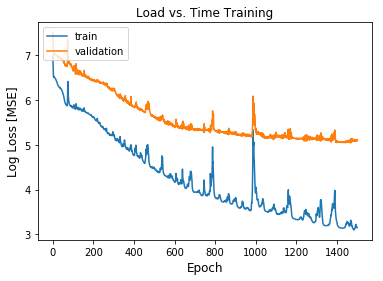

In [17]:
#list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# #plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
plt.plot(np.log(history['loss']))
plt.plot(np.log(history['val_loss']))
plt.title('Load vs. Time Training')
plt.ylabel('Log Loss [MSE]', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [104]:
from keras.models import load_model
model.save('../checkpoints/real_data_model.h5')

In [24]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (512, 381, 400)           643200    
_________________________________________________________________
lstm_6 (LSTM)                (512, 256)                672768    
_________________________________________________________________
dense_5 (Dense)              (512, 128)                32896     
_________________________________________________________________
dense_6 (Dense)              (512, 127)                16383     
Total params: 1,365,247
Trainable params: 1,365,247
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
#This should be using the "height" of the wave
max_height = max(test_out) - min(test_out)
error_sum = 0
for i in range(len(test_out)):
    error_sum += abs(test_out[i] - y_hat[i])
    
avg_error_sum = error_sum/len(test_out)
mean_abs_error_percentage = (avg_error_sum/max_height)*100
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))

mean_abs_error_percentage: 14.57369823805423


In [28]:
#Run on test data
print(len(test_x))
print(len(test_in))
print(min(test_in))

#test_x, test_y = test[0:n_prev], test[n_prev:]
#test_x = np.array(test_x)
print(len(test_in))
print
y_hat = forecast_lstm(model, test_in, n_batch)
avg_RMSE = math.sqrt(mean_squared_error(test_out, y_hat))

print("Average RMSE: " + str(avg_RMSE))


381
260
0.0
260

(256, 260)


ValueError: Error when checking : expected lstm_1_input to have shape (381, 1) but got array with shape (260, 1)

In [109]:
from keras.utils import plot_model
plot_model(model, to_file='../assets/lstm_architecture_load_v_time.png')


In [110]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (256, 381, 400)           643200    
_________________________________________________________________
lstm_28 (LSTM)               (256, 256)                672768    
_________________________________________________________________
dense_21 (Dense)             (256, 128)                32896     
_________________________________________________________________
dense_22 (Dense)             (256, 127)                16383     
Total params: 1,365,247
Trainable params: 1,365,247
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
def forecast_lstm(model, X, n_batch):
    #Reshape input data to [samples, timesteps, features] for the LSTM
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [19]:
#Run on test data
#test_x, test_y = test[0:n_prev], test[n_prev:]
test_x, test_y = test_in, test_out#test_example.values, test_label.values
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)

381
(256, 381)


## Results

In [20]:
max_height = max(test_out) - min(test_out)

abs_error = 0
for i in range(len(test_out)):
    abs_error += abs(test_out[0] - test_out[0])
    
mean_abs_error = abs_error/len(test_out)


mean_abs_error_percentage = (mean_abs_error/max_height)*100
print("Mean abs error:" + str(mean_abs_error_percentage))



print("RMSE: " + str(math.sqrt(mean_squared_error(test_out, y_hat))))




Mean abs error:0.0
RMSE: 24.4258321001


In [126]:
# print("First true label: " + str(test_y[0]))
# print("First forecast: " +str(y_hat[0]))

# print(len(test_x))
# print(len(test_y))
# print(len(y_hat))
# RMSE = []
# for i in range(33):
#     RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
# print("Average RMSE: ")
# print(sum(RMSE)/len(RMSE))
print(min(test_out))

-0.0


## Plotting initial training data

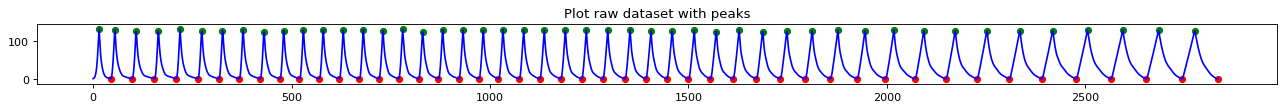

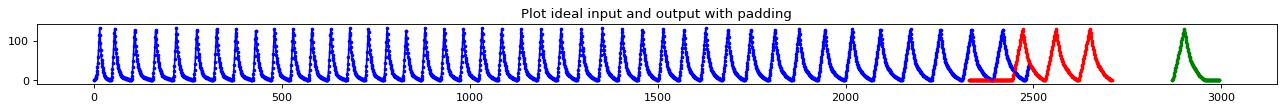

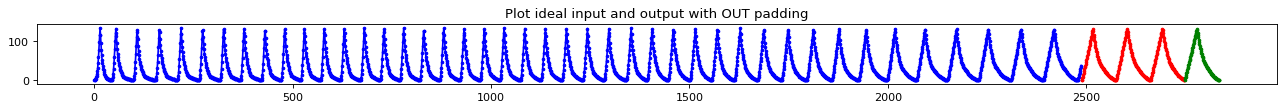

In [21]:
# (1) Plot whole dataset
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
#Line plot along the true data
plt.plot([x for x in range(len(data))], data, color="blue")
plt.title('Plot raw dataset with peaks')

#Plot the training points in green
plt.scatter(peak_times, peak_vals, color="green", s=30)
plt.scatter(trough_times, trough_vals, color="red", s=30)
plt.show()

# (2)--------------------------------------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Plot ideal input and output with padding')

test_example = test_in
test_label = test_out


#Grab the data without padding
test_in_raw = test_example#.values 
test_in = [test_in_raw[i] for i in range(len(test_in_raw)) if test_in_raw[i] >= 0]
test_out_raw = test_label#.values
test_out = [test_out_raw[i] for i in range(len(test_out_raw)) if test_out_raw[i] >= 0]
test_len = len(test_in) + len(test_out) #default_period * 4

#Plot the training data and the underlying curve in blue 
train_plot_points= data[:-test_len]
plt.plot(train_plot_points, color="blue")
train_plot_x = [x for x in range(len(train_plot_points))]
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red
test_input_plot_points = test_example#.values

test_input_xs = [x +(len(data)-len(test_example)-len(test_label)) for x in range(len(test_input_plot_points))]
#test_input_xs = [x +len(train_plot_points) for x in range(len(test_input_plot_points))]

plt.scatter(test_input_xs, test_input_plot_points, color="red", s=5)

#Plot the test target label in green
test_label_points = test_label#.values
test_label_xs = [x +(len(train_plot_points)+len(test_input_plot_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=5)
plt.show()

# (3)--------------------To better visualize, we can also remove the unused padding-----------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 1), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Plot ideal input and output with OUT padding')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="blue")
plt.scatter(train_plot_x, train_plot_points, color="blue", s=5)

#Plot the test example X in red (no padding)
test_in_xs = [x +len(train_plot_points) for x in range(len(test_in))]
plt.scatter(test_in_xs, test_in, color="red", s=5)
#plt.plot(test_in, test_in_xs, color="red")

#Plot the test target label in green (no padding)
test_label_xs = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(test_out))]
plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.plot(test_label_xs, test_out, color="green")
plt.show()

The true 'period' was: 88, and our predicted 'period' was: 79
[0.8910265, 1.0091904, 0.74149406, 1.221291, 2.967939, 6.915454, 13.21203, 20.784414, 29.468954, 37.574738, 44.465965, 49.38861, 53.312637, 56.991055, 60.846172, 65.63321, 71.769264, 79.39134, 87.82816, 96.68614, 104.52423, 110.19953, 113.564064, 115.27723, 113.96991, 110.45388, 105.49332, 99.128136, 91.87686, 83.61887, 76.28797, 68.646164, 61.717484, 56.376205, 51.455814, 47.576828, 44.071228, 41.332783, 37.871975, 34.461838, 31.40242, 27.963518, 25.805258, 25.217316, 24.199957, 23.493912, 23.090597, 22.780434, 22.075056, 21.963348, 21.343878, 19.533148, 18.018732, 16.702223, 14.127469, 12.698864, 11.765947, 9.61495, 8.815035, 7.8236384, 7.687012, 7.1608615, 7.3907957, 7.6649647, 8.019861, 8.113366, 7.6323757, 7.248496, 6.2288337, 5.097182, 3.610503, 2.3309102, 2.4798417, 4.1908417, 2.3440623, 1.1770009, 0.07001743, 2.3473682, 0.26386878, -1.879221, -0.79159474, -0.813124, -1.1758164, -0.86246777, -1.03339, -0.8521495, -1.0

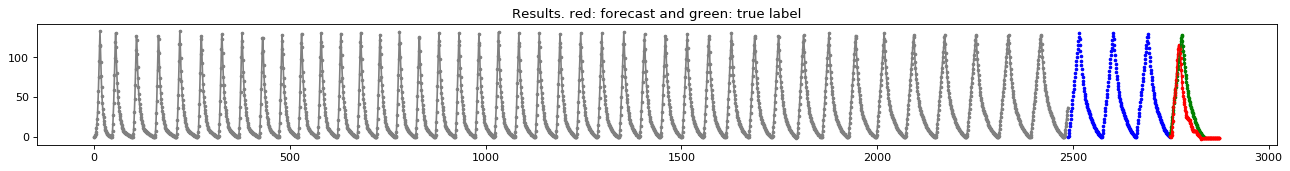

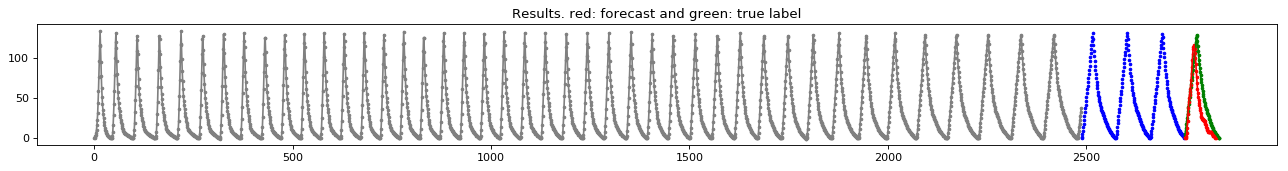

In [32]:
# (4)----Plot the actual results with padding----------------------------------------------------------------

#Plotting the dataframe results
fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="gray")
plt.title('Results. red: forecast and green: true label')
plt.scatter(train_plot_x, train_plot_points, color="gray", s=5)

#Plot the test example X in red (no padding)
plt.scatter(test_in_xs, test_in, color="blue", s=5)


#Plot the test target label in green (no padding)

#Remove padding from the prediction
#y_hat_nopad = [y_hat[i] for i in range(len(y_hat)) if y_hat[i] >= 0]

test_label_xs2 = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(y_hat))]
#print("The true 'period' was: " + str(len(test_out))+", and our predicted 'period' was: " + str(len(y_hat_nopad)))

plt.scatter(test_label_xs, test_out, color="green", s=5)
plt.plot(test_label_xs, test_out, color="green")

plt.plot(test_label_xs2, y_hat, color="red")
plt.scatter(test_label_xs2, y_hat, color="red", s=5)


# (5)----Plot the actual results without padding--------------------------------------------------------------


#Plotting the dataframe results
fig=plt.figure(figsize=(20, 2), dpi= 80, facecolor='w', edgecolor='k')

#Plot the training data and the underlying curve in blue 
plt.plot(train_plot_points, color="gray")
plt.title('Results. red: forecast and green: true label')
plt.scatter(train_plot_x, train_plot_points, color="gray", s=5)

#Plot the test example X in red (no padding)
plt.scatter(test_in_xs, test_in, color="blue", s=5)


#Plot the test target label in green (no padding)

#Remove padding from the prediction
y_hat_nopad = [y_hat[i] for i in range(len(y_hat)) if y_hat[i] >= 0]

test_label_xs2 = [x +(len(train_plot_points)+len(test_in_xs)) for x in range(len(y_hat_nopad))]
print("The true 'period' was: " + str(len(test_out))+", and our predicted 'period' was: " + str(len(y_hat_nopad)))

plt.plot(test_label_xs, test_out, color="green")
plt.scatter(test_label_xs, test_out, color="green", s=5)

plt.plot(test_label_xs2, y_hat_nopad, color="red")
plt.scatter(test_label_xs2, y_hat_nopad, color="red", s=5)

#plt.plot(y_hat, test_label_xs, color="green")

print(y_hat)
print(min(test_y))

print("first period length: " + str(periods[0]))

In [138]:
print

## Varify that the network learned to increase period

In [20]:
#In a way we can just treat the number of non-negative points as the length of the period

init_period = periods[0]

print("Init period: " + str(init_period))
print("True holder size " + str(len(test_out_raw)))
print("Predicted holder size: "+str(len(y_hat)))
print("Predicted period size: "+str(len(y_hat_nopad)))
print("True period size: " + str(len(test_out)))




Init period: 54
True holder size 127
Predicted holder size: 127
Predicted period size: 79
True period size: 88


## Evaluate the forecast based on its RMSE and record results

In [21]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


NameError: name 'n_forecast' is not defined